# Лабораторная работа № 4: Экстраполяция населения США
# Клименко Виталий Б01-203

---

## Цель работы:
Решить задачу экстраполяции населения страны методами: 

1. Классическая полиномиальная интерполяция по Ньютону
2. Сплайн-интерполяция
3. Метод наименьших квадратов

---

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
data = {1910 : 92228496,
        1920 : 106021537,
        1930 : 123202624,
        1940 : 132164569,
        1950 : 151325798,
        1960 : 179323175,
        1970 : 203211926,
        1980 : 226545805,
        1990 : 248709873,
        2000 : 281421906}

# Классическая полиномиальная интерполяция по Ньютону

In [2]:
def divided_differences(x, y):
    n = len(y)
    coef = np.zeros((n, n))
    coef[:, 0] = y

    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j] - x[i])
    return coef[0]

In [3]:
def newton_polynomial(x, y, x_interp):
    n = len(x)
    a = divided_differences(x, y)
    
    P = a[0]
    for i in range(1, n):
        term = a[i]
        for j in range(i):
            term *= (x_interp - x[j])
        P += term
        
    return P

4774878490.000001


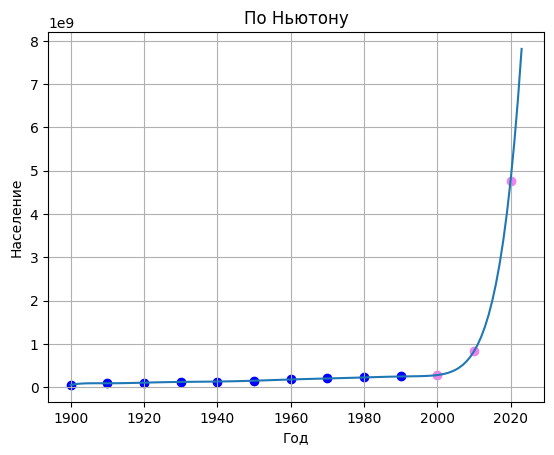

In [4]:
years = np.array(list(data.keys()))
populations = np.array(list(data.values()))
estimated_population = newton_polynomial(years, populations, 2020)
print(estimated_population)
estimated_population_data_ = [newton_polynomial(years, populations, i) for i in range(1900, 2024)]
x_ = [i for i in range(1900, 2024)]
estimated_population_data = [newton_polynomial(years, populations, i) for i in range(1900, 2024, 10)]
x = [i for i in range(1900, 2024, 10)]
plt.plot(x_, estimated_population_data_, )
plt.scatter(x[:10], estimated_population_data[0:10], color = 'blue')
plt.xlabel('Год')
plt.ylabel('Население')
plt.grid()
plt.title("По Ньютону")
plt.scatter(x[10:], estimated_population_data[10:], color = 'violet')
plt.show()

# Сплайн-интерполяция

In [5]:
def construct_spline_coefficients(years, populations):
    n = len(years)
    
    A = np.zeros((n, n))
    b = np.zeros(n)

    A[0][0] = 1
    A[n-1][n-1] = 1

    for i in range(1, n - 1):
        h_i = years[i] - years[i - 1]
        h_next = years[i + 1] - years[i]
        
        A[i][i - 1] = h_i
        A[i][i] = 2 * (h_i + h_next)
        A[i][i + 1] = h_next
        
        b[i] = (populations[i + 1] - populations[i]) / h_next - (populations[i] - populations[i - 1]) / h_i

    c = np.linalg.solve(A, b)

    a = populations[:-1]
    b_coeffs = np.zeros(n - 1)
    d_coeffs = np.zeros(n - 1)

    for i in range(n - 1):
        h = years[i + 1] - years[i]
        
        if i == n - 2:
            b_coeffs[i] = (populations[i + 1] - populations[i]) / h - (2 * c[i] + c[i + 1]) * h / 3
            d_coeffs[i] = (c[i + 1] - c[i]) / (3 * h)
        else:
            b_coeffs[i] = (populations[i + 1] - populations[i]) / h - (c[i + 1] * h) / 3
            d_coeffs[i] = (c[i + 1] - c[i]) / (3 * h)

    return a, b_coeffs, c, d_coeffs

def spline(x, years, a, b_coeffs, c, d_coeffs):
    for i in range(len(years) - 1):
        if years[i] <= x <= years[i + 1]:
            dx = x - years[i]
            return a[i] + b_coeffs[i] * dx + c[i] * dx**2 + d_coeffs[i] * dx**3
            
    if x < years[0]:
        dx = x - years[0]
        return a[0] + b_coeffs[0] * dx + c[0] * dx**2 + d_coeffs[0] * dx**3
    elif x > years[-1]:
        dx = x - years[-2]
        return a[-1] + b_coeffs[-1] * dx + c[-1] * dx**2 + d_coeffs[-1] * dx**3
            
    return None

def plot_spline(years, populations, x_interp, y_interp):
    plt.figure(figsize=(10,5))
    plt.plot(years, populations, 'o', label='Исходные данные', color='blue')
    plt.plot(x_interp, y_interp, label='Кубический сплайн', color='blue')
    plt.axvline(x=years[0], color='gray', linestyle='--')
    plt.axvline(x=years[-1], color='gray', linestyle='--')
    plt.title('Экстраполяция c помощью кубического сплайна')
    plt.xlabel('Год')
    plt.ylabel('Население')
    plt.grid()
    plt.show()

[1324545.72164755 1824207.34674312  800529.69137995 1852707.35440375
 2854526.42433839 2370089.94824269 2372235.51602417 2118795.18766062
 3075980.07532125] 9


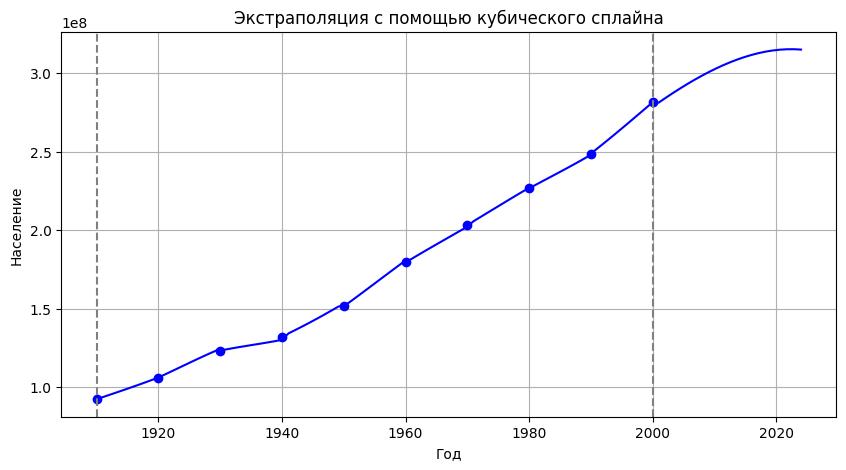

In [6]:
a, b_coeffs, c, d_coeffs = construct_spline_coefficients(years, populations)
x_interp = np.linspace(years[0], 2024, num=100)
y_interp = [spline(x, years, a, b_coeffs, c, d_coeffs) for x in x_interp]
print(b_coeffs, len(b_coeffs))
plot_spline(years, populations, x_interp, y_interp)

# Метод наименьших квадратов

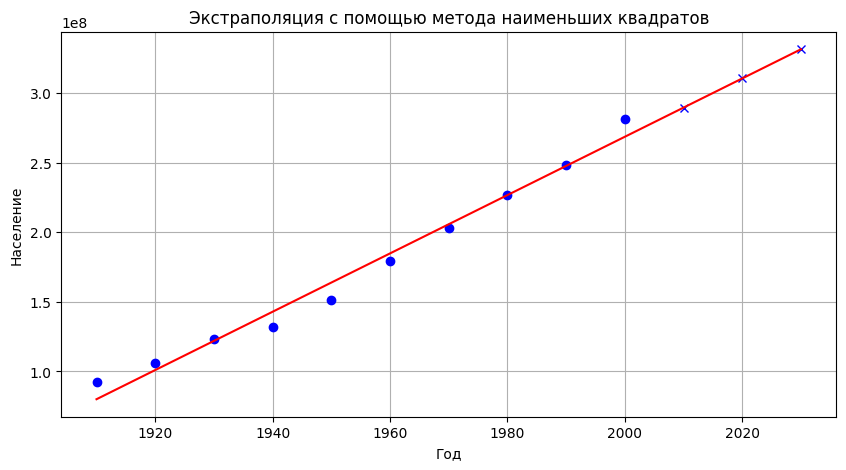

In [7]:
def linear_regression(years, populations):
    X = np.vstack([years, np.ones(len(years))]).T
    a, b = np.linalg.lstsq(X, populations, rcond=None)[0]
    return a, b

def extrapolate(future_years, a, b):
    X_future = np.vstack([future_years, np.ones(len(future_years))]).T
    predicted_populations = X_future @ np.array([a, b])
    return predicted_populations

def plot_results(years, populations, future_years, predicted_populations, a, b):
    plt.figure(figsize=(10, 5))
    plt.plot(years, populations, 'o', label='Исходные данные', color='blue') 
    plt.plot(future_years, predicted_populations, 'x', label='Экстраполяция', color='blue') 
    years_all = np.hstack([years, future_years])
    plt.plot(years_all, a * years_all + b, label='Линейная модель', color='red') 
    plt.title('Экстраполяция с помощью метода наименьших квадратов')
    plt.xlabel('Год')
    plt.ylabel('Население')
    plt.grid()
    plt.show()

a, b = linear_regression(years, populations)
future_years = np.array([2010, 2020, 2030])
predicted_populations = extrapolate(future_years, a, b)
plot_results(years, populations, future_years, predicted_populations, a, b)